# Modelo de Clasificación (ResNet18) para análisis de  Radiografías de Tórax (Normal versus Neumonía): 

## Objetivo:

El objetivo del proyecto es programar y evaluar un modelo para clasificación binaria, que a partir de radiografías de tórax determine si la imagen puede ser clasificada como NORMAL o PNEUMONIA. Para el entrenamiento se usarán datos de acceso público con el fin de ser un aporte en aquellos casos donde muchas radiografías no son informadas por un radiólogo.

## Introducción:

En periodos de alta demanda, particularmente en el periodo invernal, la radiografía  de tórax es uno de los estudios más solicitados, sin embargo suele ser uno de los examenes que suele no ser informado por profesional radiólogo, lo que obliga a los clínicos realizar la intepretación inicial. Considerando que la neumonía es de los diagnósticos más relevantes en este tipo de exámenes, además de ser un resultado crítico, por lo que su detección oportuna influye fuertemente en el manejo y derivación impactando negativamente en la optimización de los recuersos. Es por esta razón que un clasificador automático puede priorizar la atención en casos que resulten sospechosos, sin la necesidad de reemplazar la lectura por parte de un experto. Para este fin se entrenará un clasificaddor CNN (*Convolutional neural network*), en este caso ResNet18 preentrenada en ImagenNet, que sea capaz de distinguir entre dos resultados posibles (NORMAL VS PNEUMONIA), maximizando F1 y recall de la clase positiva.
En el siguiente proyecto se documentan la fuente y preparación de los datos para entrenamiento, el preprocesamiento y augmentación, arquitectura e hiperparámetros; estrategia de partición y manejo del desbalance; las métricas obtenidas y curvas de aprendizaje; evaluación en test; interpretación y limitaciones. Es importante considerar que en el presente no se alcanza a abordar el despliegue del modelo en un espacio clínico ni validación multicéntrica.

## Entrenamiento

In [2]:
# Llamado de librerías
import os
import random
from collections import Counter
from pathlib import Path

import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms, models
from torch.optim.lr_scheduler import ReduceLROnPlateau

from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedShuffleSplit

In [3]:
#  Descarga automática del dataset de Kaggle si no existe 
#from pathlib import Path
#import os

#DATA_ROOT = Path("data/chest_xray")  # Se mantiene ruta
#if not DATA_ROOT.exists():
#    try:
        # instalar y autenticar Kaggle API
#        import subprocess, sys
#        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "kaggle"])
#        from kaggle.api.kaggle_api_extended import KaggleApi

#        os.makedirs("data", exist_ok=True)
#        api = KaggleApi(); api.authenticate()
#        print("Descargando dataset de Kaggle (puede tardar unos minutos)...")
#        api.dataset_download_files(
#            "paultimothymooney/chest-xray-pneumonia",
#            path="data", unzip=True
#        )
#        assert DATA_ROOT.exists(), "No se encontró la carpeta 'data/chest_xray' después de descomprimir."
#        print("Dataset descargado y listo en", DATA_ROOT)
#    except Exception as e:
#        print("No se pudo descargar automáticamente el dataset.")
#        print("Crea tu token en https://www.kaggle.com/settings/account y coloca 'kaggle.json' en ~/.kaggle/")
#        print("Error:", e)

Se añade este código para descarga automática del dataset desde Kaggle.
El dataset público, de nombre Chest X-Ray (Pneumonia), de Paul Mooney.

In [4]:
# Reproducibilidad 
SEED = 42
random.seed(SEED); np.random.seed(SEED)
torch.manual_seed(SEED)

Se fijan las semillas en PyTorch para que los resultados sean lo más reproducibles posible.

In [5]:
# Rutas
DATA_ROOT = Path("data/chest_xray")
TRAIN_DIR = DATA_ROOT / "train"
VAL_DIR   = DATA_ROOT / "val"   
TEST_DIR  = DATA_ROOT / "test"
os.makedirs("artifacts", exist_ok=True)

Se definen las carpetas con su estructura ImageFolder, además se crea la carpeta artifacts/, en ella se guardará el mejor modelo, las métricas y los gráficos de resultados obtenidos.

In [6]:
# Hiperparámetros
IMG_SIZE = 224
BATCH_SIZE = 32
LR = 1e-4
EPOCHS = 15  # N° de Épocas

device = torch.device("cpu")
print("Device:", device)

Device: cpu


Se definen los hiperparámetros, el modelo preentrenado ResNet18 utiliza como tamaño estándar 224 x 224. El batch de 32 representa el  número de imágenes por actualización de gradiente (compromiso entre estabilidad de gradiente y memoria GPU). Se utiliza un learning rate (LR) conservador para fine-tuning estable. Se determina el N° de épocas (15), aunque el early stopping hace el corte definitivo.

In [7]:
# Chequeo de estructura y conteo
def print_split_counts(root: Path):
    if not root.exists():
        print(f"{root.name} no existe.")
        return
    print(f"{root.name} folders:")
    for cls in sorted(os.listdir(root)):
        cls_path = root / cls
        if cls_path.is_dir():
            n = len(os.listdir(cls_path))
            print(f"  {cls}: {n} imágenes")

for split_dir in [TRAIN_DIR, VAL_DIR, TEST_DIR]:
    print_split_counts(split_dir)

train folders:
  NORMAL: 1341 imágenes
  PNEUMONIA: 3875 imágenes
val folders:
  NORMAL: 8 imágenes
  PNEUMONIA: 8 imágenes
test folders:
  NORMAL: 234 imágenes
  PNEUMONIA: 390 imágenes


Se realiza un sanity check inicial, se recorre cada split y se reporta el N° de imágenes por clase. De esta forma es posible detectar desbalances o errores de estructuras, como carpetas vacías o clases mal nombradas.

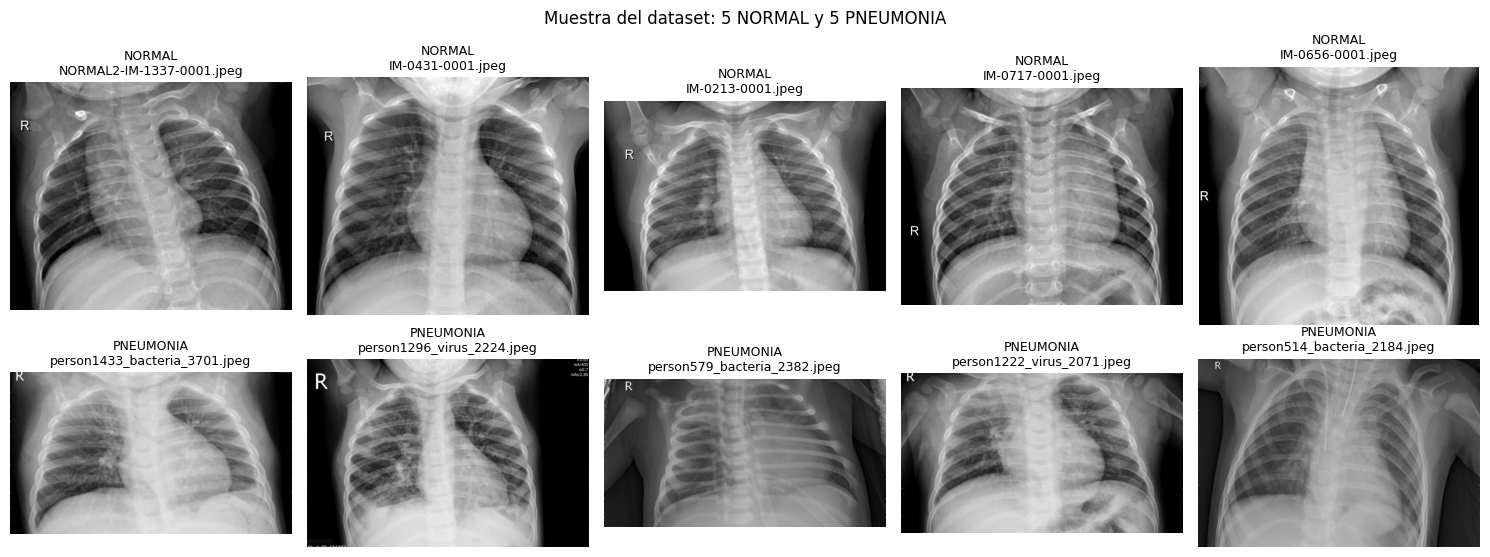

In [8]:
# Muestra de las imágenes del dataset
def _collect_images(base_dir: Path, cls: str, k: int = 5):
    """Toma hasta k imágenes de base_dir/cls; si no hay suficientes, intenta en TEST y VAL."""
    candidates = []
    for split in [base_dir, TEST_DIR, VAL_DIR]:
        cls_dir = split / cls
        if cls_dir.exists():
            files = [p for p in cls_dir.iterdir() if p.suffix.lower() in {".jpg", ".jpeg", ".png", ".bmp"}]
            candidates.extend(files)
        if len(candidates) >= k:
            break
    k = min(k, len(candidates))
    return random.sample(candidates, k) if k > 0 else []

normal_paths    = _collect_images(TRAIN_DIR, "NORMAL", k=5)
pneumonia_paths = _collect_images(TRAIN_DIR, "PNEUMONIA", k=5)

n_cols = max(len(normal_paths), len(pneumonia_paths))
n_rows = 2
plt.figure(figsize=(3*n_cols, 3*n_rows))

# NORMAL
for i, p in enumerate(normal_paths, start=1):
    ax = plt.subplot(n_rows, n_cols, i)
    img = Image.open(p).convert("L")  # mostrar en escala de grises
    ax.imshow(img, cmap="gray")
    ax.set_title(f"NORMAL\n{p.name}", fontsize=9)
    ax.axis("off")

# PNEUMONIA
start = n_cols + 1
for j, p in enumerate(pneumonia_paths, start=start):
    ax = plt.subplot(n_rows, n_cols, j)
    img = Image.open(p).convert("L")
    ax.imshow(img, cmap="gray")
    ax.set_title(f"PNEUMONIA\n{p.name}", fontsize=9)
    ax.axis("off")

plt.suptitle("Muestra del dataset: 5 NORMAL y 5 PNEUMONIA", fontsize=12)
plt.tight_layout()
plt.show()

En la muestra del dataset, ser observan 5 radiografías de cada clase (NORMAL y PNEUMONIA), en ellas se puede observar que a simple vista las diferencias entre ambos diagnósticos suelen ser sutiles, y frente a la evaluación de un ojo no entrenado podría incluso no identificarse la patología, por este motivo un modelo de clasificación podría ser de utilidad en el apoyo clínico.

In [9]:
# Definir transformations
train_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=7),
    transforms.Grayscale(num_output_channels=3), #Redes preentrenadas en ImageNet esperan 3 canales
    transforms.ToTensor(),    # Convierte a tensor y escala a [0,1] para la siguiente normalización
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std =[0.229, 0.224, 0.225])
])

eval_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std =[0.229, 0.224, 0.225])
])

Se realiza augmentación y normalización de los datos.
La augmentación crea variaciones en los datos sin alterar la etiqueta (normal vs neumonía) de los mismos, con esto se busca reducir el sobreajuste y hacer al modelo invariante a pequeñas diferencias de adquisición o posición de la imagen, en este caso se realizan flip horizontales y leves rotaciones. Se replica el canal en 3, esto permite usar pesos preentrenados sin modificar la arquitectura.
Además se realiza normalización de los datos con las estadísticas de ImageNet (mean=[0.485, 0.456, 0.406]) y (std=[0.229, 0.224, 0.225]) mejorando la transferencia con el modelo preentrenado.

In [10]:
# Cargar datasets (ImageFolder) y crear split estratificado si no hay val/
# Dataset base de train (con transform de TRAIN)
train_base = datasets.ImageFolder(root=str(TRAIN_DIR), transform=train_tfms)
test_dataset = datasets.ImageFolder(root=str(TEST_DIR), transform=eval_tfms)

if "USE_ORIGINAL_VAL" not in globals():
    USE_ORIGINAL_VAL = False

if USE_ORIGINAL_VAL and VAL_DIR.exists():
    val_dataset   = datasets.ImageFolder(root=str(VAL_DIR), transform=eval_tfms)
    train_dataset = train_base
else:
    try:
        targets = train_base.targets
    except AttributeError:
        targets = [s[1] for s in train_base.samples]

  # Crea una validación estratificada 80/20 a partir de train/
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=SEED)
    idx_train, idx_val = next(sss.split(np.zeros(len(targets)), targets))

    train_dataset = Subset(train_base, idx_train)
    # Val reutiliza los paths de train pero con eval_tfms
    val_base_only_paths = datasets.ImageFolder(root=str(TRAIN_DIR), transform=eval_tfms)
    val_dataset = Subset(val_base_only_paths, idx_val)

# Chequeo de clases
classes = train_base.classes
print("Clases:", classes)  

# DataLoaders optimizados

PIN = False
NUM_WORKERS = 2 if os.name == "nt" else 4  

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=PIN)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=PIN)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=PIN)

# Sanity check de un batch
images, labels = next(iter(train_loader))
print("Batch shape:", images.shape, "Labels shape:", labels.shape)

Clases: ['NORMAL', 'PNEUMONIA']
Batch shape: torch.Size([32, 3, 224, 224]) Labels shape: torch.Size([32])


Con esta línea se cargan los ImageFolder con augmentación y normalizados.
El código esta pensado para ofrecer dos alternativas de ruta, una es usar la carpeta val/ original en caso de que exista, o crear una validación estratificada 80/20 a partir de train/, esto produce una validación más robusta ya que val/ del dataset original es pequeña y menos representativa (8 NORMAL y 8 PNEUMONIA).
Aquí se crean los ImageFolder apuntando a TRAIN_DIR, uno con transforms de entrenamiento y el otro con transforms de evaluación. Ambos subconjuntos proceden de la misma carpeta, pero la validación no recibe augmentación. Al separar los datasets y transforms se evitan fugas de aleatoriedad.
Se configuran los DataLoader solo en entrenamiento (True), para romper correlaciones entre batches. 
Se incluye además un sanity check a un batch, mostrando las formas tensoriales esperadas.

Ejemplos recolectados para NORMAL: 3
Ejemplos recolectados para PNEUMONIA: 3


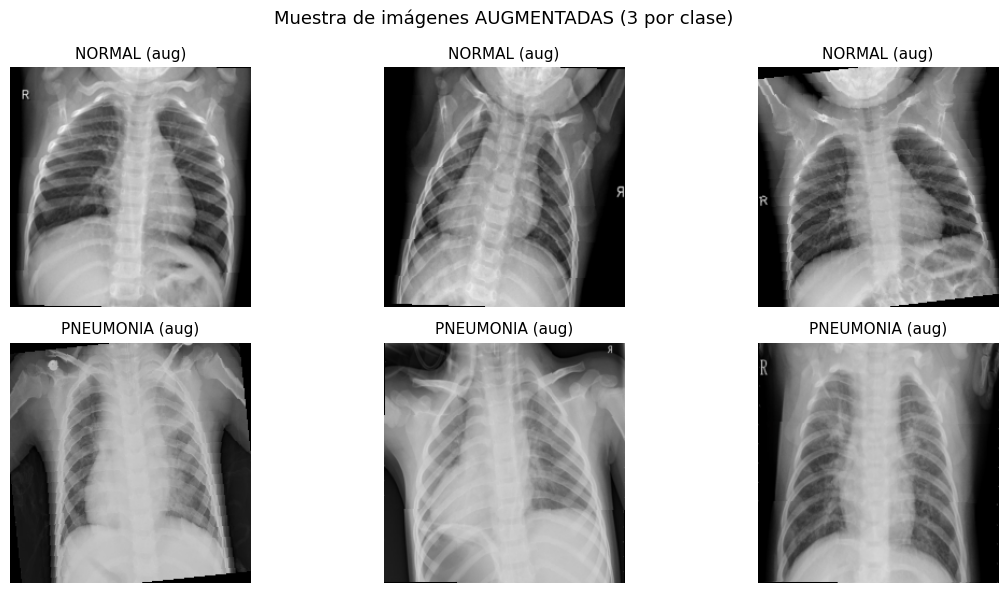

In [11]:
# Muestra de imagenes con augmentación aplicada
_IMAGENET_MEAN = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
_IMAGENET_STD  = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)

def denorm(img_t: torch.Tensor) -> np.ndarray:
    x = img_t.detach().cpu() * _IMAGENET_STD + _IMAGENET_MEAN
    x = x.clamp(0,1)
    return x.permute(1,2,0).numpy()

# Recolecta 3 por clase recorriendo batches 
needed_per_class = 3
samples = {0: [], 1: []}  # 0 = NORMAL, 1 = PNEUMONIA (según 'classes')

for images, labels in train_loader:
    for img, y in zip(images, labels):
        y = int(y.item())
        if len(samples[y]) < needed_per_class:
            samples[y].append(denorm(img))
    
    if all(len(samples[c]) >= needed_per_class for c in samples):
        break

# Por si alguna clase no alcanzó 3
for c in (0,1):
    if len(samples[c]) == 0:
        print(f"Advertencia: no se encontraron ejemplos para la clase {classes[c]}")
    else:
        print(f"Ejemplos recolectados para {classes[c]}: {len(samples[c])}")

# Plot: fila 1 = NORMAL, fila 2 = PNEUMONIA (3 columnas)
ncols = max(len(samples[0]), len(samples[1]))
ncols = min(ncols, needed_per_class) if ncols > 0 else needed_per_class
plt.figure(figsize=(4*ncols, 6))

# Fila NORMAL (clase 0)
for i, im in enumerate(samples[0][:needed_per_class], start=1):
    ax = plt.subplot(2, ncols, i)
    ax.imshow(im, cmap=None)
    ax.set_title(f"{classes[0]} (aug)", fontsize=11)
    ax.axis("off")

# Fila PNEUMONIA (clase 1)
for i, im in enumerate(samples[1][:needed_per_class], start=1):
    ax = plt.subplot(2, ncols, ncols + i)
    ax.imshow(im, cmap=None)
    ax.set_title(f"{classes[1]} (aug)", fontsize=11)
    ax.axis("off")

plt.suptitle("Muestra de imágenes AUGMENTADAS (3 por clase)", fontsize=13)
plt.tight_layout()
plt.show()

Se muestra un ejemplo de las imágenes con augmentación aplicada, de esta forma se busca reducir el sobreajuste al momento de entrenar el modelo, se han realizado flip horizontales y ligeras rotaciones a las imágenes.

In [12]:
# Modelo (ResNet18) + pérdida con pesos de clase (robusta)
def get_train_targets(dataset, base_dataset):
    """Recupera etiquetas verdaderas del conjunto de entrenamiento (compat Subset/ImageFolder)."""
    try:
        base_targets = base_dataset.targets
    except AttributeError:
        base_targets = [s[1] for s in base_dataset.samples]
    if isinstance(dataset, Subset):
        return [base_targets[i] for i in dataset.indices]
    else:
        return base_targets

train_targets = get_train_targets(train_dataset, train_base) # Refleja las clases del split del que aprende el modelo
counts = Counter(train_targets)  # Distribución real por clases
print("Distribución de clases en train:", counts)

n0, n1 = counts.get(0, 0), counts.get(1, 0)
total = n0 + n1
w0 = total / (2.0 * n0) if n0 > 0 else 1.0
w1 = total / (2.0 * n1) if n1 > 0 else 1.0
class_weights = torch.tensor([w0, w1], dtype=torch.float32) # Se crean los pesos como un tensor
print("Pesos de clase:", class_weights)

model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)  # 2 clases
model = model.to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights) # Se define la pérdida
optimizer = optim.Adam(model.parameters(), lr=LR)

# ReduceLROnPlateau y early stopping 
scheduler = ReduceLROnPlateau(optimizer, mode="max", factor=0.5, patience=2)

early_stop_patience = 3
epochs_no_improve = 0
best_f1 = -float("inf")

Distribución de clases en train: Counter({1: 3099, 0: 1073})
Pesos de clase: tensor([1.9441, 0.6731])


Este es el bloque de entrenamiento, que tiene 3 objetivos: (1)Conocer la distribución de las clases en el conjunto de entrenamiento que se utilizará. (2)Definir una pérdida robusta al desbalance mediante pesos de clase. (3)Prepara un modelo ResNet18 preentrenado.
Al obtener la distribución real por clase, se calculan los pesos inversos a la frecuencia para cada clase. Esto hace que la suma de los pesos sea ≈1 por clase, y que los errores en la clase minoritaria cuenten más durante la optimización.
Luego se prepara el modelo preentrenado aprovechando los filtros en ImageNet para texturas y bordes genéricos y se sustituye la capa final por una lineal con 2 salidas.
Se define la pérdida incorporando la ponderación por desbalance directamente en la función objetivo, elevando el gradiente de la clase infrarrepresentada.
Se inicializa el scheduler en modo max para monitorizar la métrica que se quiere maximizar (F1 en validación)
Finalmente se configuran las variables de early stopping para cortar el entrenamiento si no hay mejoras reales en un número razonable de épocas(3), evitando sobreentrenar y optimizando los tiempos de entrenamiento.

ResNet18 es una red neuronal convolucional de 18 capas que resulta ser un excelente extractor de características y transfer learning, cuando se busca un equilibrio entre precisión y ligereza computacional.
https://docs.pytorch.org/vision/2.0/models/generated/torchvision.models.resnet18.html

In [11]:
# Métricas 
def get_probs_and_preds(logits: torch.Tensor):
    probs = torch.softmax(logits, dim=1)[:, 1]
    preds = torch.argmax(logits, dim=1)
    return probs, preds

def eval_loader_metrics(model, loader, device, pos_label=1, criterion=None, print_summary=False):
    model.eval()
    all_y, all_pred = [], []
    running_loss, n_samples = 0.0, 0

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            if criterion is not None:
                loss = criterion(logits, y)
                running_loss += loss.item() * x.size(0)
                n_samples += x.size(0)
            _, preds = get_probs_and_preds(logits)
            all_y.append(y.cpu()); all_pred.append(preds.cpu())

    y_true = torch.cat(all_y).numpy()
    y_pred = torch.cat(all_pred).numpy()

    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average="binary", pos_label=pos_label
    )
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    avg_loss = (running_loss / n_samples) if (criterion is not None and n_samples > 0) else None

    if print_summary:
        print("\n Métricas:")
        if avg_loss is not None:
            print(f"  Loss:         {avg_loss:.4f}")
        print(f"  Accuracy:     {acc:.4f}")
        print(f"  Precision:    {prec:.4f}")
        print(f"  Recall:       {rec:.4f}")
        print(f"  F1-score:     {f1:.4f}")
        print(f"  Matriz de confusión:\n{cm}")

    return {"loss": avg_loss, "acc": acc, "precision": prec, "recall": rec, "f1": f1}

Se pone el modelo en modo evaluación y se reportarn accuracy, precision, recall y F1 más la matriz de confusión.

## Análisis de Resultados

In [15]:
# Entrenamiento + registro de métricas
hist_epochs = []
hist_train_loss, hist_val_loss = [], []
hist_train_acc,  hist_val_acc  = [], []
hist_train_f1,   hist_val_f1   = [], []

best_f1 = -np.inf

for epoch in range(1, EPOCHS + 1):
    model.train()
    running_loss = 0.0

    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad(set_to_none=True)

        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * x.size(0)

    train_loss_epoch = running_loss / len(train_loader.dataset)
    train_metrics = eval_loader_metrics(model, train_loader, device, criterion=criterion, print_summary=False)
    val_metrics   = eval_loader_metrics(model,   val_loader, device, criterion=criterion, print_summary=True)

    # ===== Log / historiales =====
    hist_epochs.append(epoch)

    # Loss: para train se utiliza el calculado en el loop; para val el de eval
    hist_train_loss.append(train_loss_epoch)
    hist_val_loss.append(val_metrics["loss"])

    # Acc y F1 de train/val
    hist_train_acc.append(train_metrics["acc"])
    hist_val_acc.append(val_metrics["acc"])
    hist_train_f1.append(train_metrics["f1"])
    hist_val_f1.append(val_metrics["f1"])

    # Guardar mejor modelo por F1 de validación
    if val_metrics["f1"] > best_f1:
        best_f1 = val_metrics["f1"]
        torch.save(model.state_dict(), "artifacts/best_model_resnet18.pth")
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    # Scheduler sobre F1 de validación
    scheduler.step(val_metrics["f1"])

    print(f"\n===== Epoch {epoch}/{EPOCHS} =====")
    print(f"Train - Loss: {train_loss_epoch:.4f} | Acc: {train_metrics['acc']:.4f} | F1: {train_metrics['f1']:.4f}")
    print(f"Val   - Loss: {val_metrics['loss']:.4f} | Acc: {val_metrics['acc']:.4f} | F1: {val_metrics['f1']:.4f}")


    # Early stopping
    if epochs_no_improve >= early_stop_patience:
        print(f" Early stopping: {early_stop_patience} épocas sin mejorar F1 en validación.")
        break


 Métricas:
  Loss:         0.0936
  Accuracy:     0.9492
  Precision:    0.9986
  Recall:       0.9330
  F1-score:     0.9647
  Matriz de confusión:
[[267   1]
 [ 52 724]]

===== Epoch 1/15 =====
Train - Loss: 0.1326 | Acc: 0.9751 | F1: 0.9830
Val   - Loss: 0.0936 | Acc: 0.9492 | F1: 0.9647

 Métricas:
  Loss:         0.0673
  Accuracy:     0.9617
  Precision:    0.9986
  Recall:       0.9497
  F1-score:     0.9736
  Matriz de confusión:
[[267   1]
 [ 39 737]]

===== Epoch 2/15 =====
Train - Loss: 0.0584 | Acc: 0.9751 | F1: 0.9830
Val   - Loss: 0.0673 | Acc: 0.9617 | F1: 0.9736

 Métricas:
  Loss:         0.0533
  Accuracy:     0.9904
  Precision:    0.9898
  Recall:       0.9974
  F1-score:     0.9936
  Matriz de confusión:
[[260   8]
 [  2 774]]

===== Epoch 3/15 =====
Train - Loss: 0.0474 | Acc: 0.9827 | F1: 0.9885
Val   - Loss: 0.0533 | Acc: 0.9904 | F1: 0.9936

 Métricas:
  Loss:         0.0385
  Accuracy:     0.9828
  Precision:    0.9987
  Recall:       0.9781
  F1-score:     0

Se realiza el entrenamiento del modelo en las épocas programadas (15) el early stopping detiene proceso en época 13/15 al no detectar mejoras en el F1 en validación en 3 épocas.
Un análisis global de los datos obtenidos, muestra una convergencia rápida de F1 desde la época 1, manteniéndose los valores altos desde ahí. Se observa también que el modelo oscila entre "más precisión" (casi sin falsos positivos) y "más recall (casi sin falsos negativos) entre las épocas 6-9, lo que muestra la oscilación entre sensibilidad y especificidad.
El mejor resultado (checkpoint) se alcanza en época 10, con un F1 de validación de 0.9961; y al observar la Matriz de confusión de esta época [[266,2],[4,772]] se obtienen 2 falsos positivos y 4 falsos negativos, con una precisión de 0.9974 y un recall de 0.9948.
Al analizar aspectos relevantes de la Matriz de confusión en cada época, llama la atención:
- En época 1, casi no se detectan falsos positivos (1), pero los falsos negativos se elevan considerablemente (52).
- En época 3, se observa un recall alto de 0.9974 , pero con caída de la precisión 0.9898, observándose un leve aumento de los falso positivos.
- En época 9, se obtiene precisión perfecta 1.0000, pero el recall baja a 0.9575, no se observan falsos positivos, pero aumentan los falsos negativos.
Al analizar estos datos, se observa que el modelo generaliza bien en validación, que probablemente el uso de pesos de clase más la pequeña augmentación aplicada ayudaron a que no se genere un sobreajuste sostenido durante el entrenamiento del modelo.

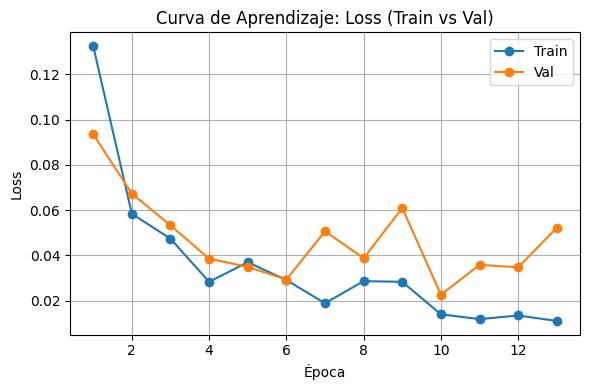

In [16]:
# Loss (Train vs Val)
plt.figure(figsize=(6,4))
plt.plot(hist_epochs, hist_train_loss, marker='o', label='Train')
plt.plot(hist_epochs, hist_val_loss,   marker='o', label='Val')
plt.xlabel("Época"); plt.ylabel("Loss")
plt.title("Curva de Aprendizaje: Loss (Train vs Val)")
plt.grid(True); plt.legend(); plt.tight_layout()
plt.savefig("artifacts/curve_loss.png", dpi=150)
plt.show()

El gráfico de Loss (Train vs Val) muestra una rápida convergencia, desde la época 1 a 4, el loss cae de 0.1326 a 0.0283 en Train y de 0.0936 a 0.0385 en Val, lo que se condice con la subida del F1 (observar gráfico siguiente).
En general la separación entre Train y Val es corta en caso todo el entrenamiento, no observándose sobreajuste sostenido. El train loss disminuye y el val loss lo sigue, aunque presenta un poco más de ruido.
Se observa un bache entre épocas 7-9, val loss aumenta y train loss disminuye, aunque no representa un sobreajuste importante.
En la época 10, el val loss cae al mínimo local (punto donde el F1 val llega al máximo, ver gráfico siguiente), a partir de este punto no se observan variaciones significativas, el early stopping corta en época 13, tras 3 épocas sin mejorar en F1.

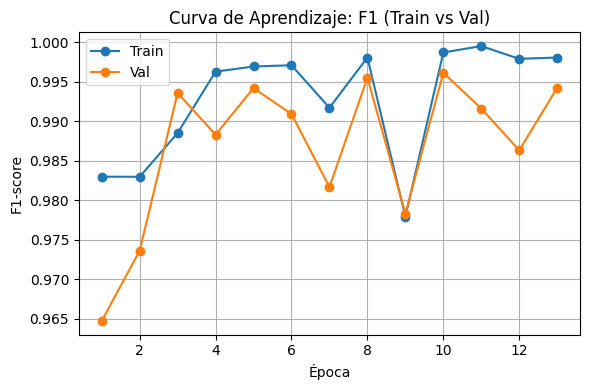

In [17]:
# F1 (Train vs Val)
plt.figure(figsize=(6,4))
plt.plot(hist_epochs, hist_train_f1, marker='o', label='Train')
plt.plot(hist_epochs, hist_val_f1,   marker='o', label='Val')
plt.xlabel("Época"); plt.ylabel("F1-score")
plt.title("Curva de Aprendizaje: F1 (Train vs Val)")
plt.grid(True); plt.legend(); plt.tight_layout()
plt.savefig("artifacts/curve_f1.png", dpi=150)
plt.show()

El gráfico de F1 (Train vs Val) muestra una subida ráída de F1 Val de 0.9736 a 0.9936, lo que indica que el modelo aprende patrones útiles rápidamente.
Se observa una meseta alta en F1 Train entre las épocas 4-6, mostrando además una brecha entre train y val estrecha, lo que indica buena generalización por parte del modelo.
Llama la atención un bache sincronizado en las épocas 7 y 9, particularmente en la época 9 esta caída del F1 coincide con la priorización de precisión, y al analizar la matriz de confusión de dicha época se observa como suben los falsos negativos, no se trata de una inestabilidad del entrenamiento del modelo, sino un cambio de trade-off, que reduce el F1 (se logran menos falsos positivos, pero más falsos negativos).
Se logra el mejor rendimiento en la época 10 (checkpoint), posterior a esto, se observa una ligera oscilación en valores altos, sin tendencia al sobreajuste.

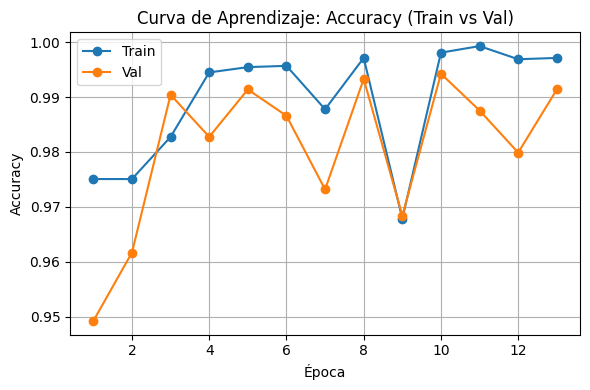

In [18]:
# Accuracy (Train vs Val)
plt.figure(figsize=(6,4))
plt.plot(hist_epochs, hist_train_acc, marker='o', label='Train')
plt.plot(hist_epochs, hist_val_acc,   marker='o', label='Val')
plt.xlabel("Época"); plt.ylabel("Accuracy")
plt.title("Curva de Aprendizaje: Accuracy (Train vs Val)")
plt.grid(True); plt.legend(); plt.tight_layout()
plt.savefig("artifacts/curve_acc.png", dpi=150)
plt.show()

El gráfico de Accuracy (Train vs Val) muestra una escalada incial, coherente con la caída de loss evidenciada en el gráfico Loss (Train vs Val).
Se observa una meseta alta con una brecha pequeña entre las épocas 4-6, train oscila entre 0.9945 - 0.9957 y val en 0.9828-0.9914, sin evidencias se sobreajuste sostenido.
Se observan los baches sincronizados de las épocas 7 y 9, en Val el accuracy baja a 0.9732 (ép 7) y 0.9684 (ép 9), lo que coincide con el trade-off mencionado en el análisis del gráfico anterior.
El mejor punto se alcanza en la época 10, y de aquí en adelante el Accuracy se mantiene alto en Val, hasta que el early stopping detiene el proceso.

## Evaluación

In [19]:
def collect_probs_preds(model, loader, device):
    model.eval()
    ys, preds, probs = [], [], []
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            logits = model(x)
            p  = torch.softmax(logits, dim=1)[:, 1].cpu().numpy()
            pr = torch.argmax(logits, dim=1).cpu().numpy()
            ys.append(y.numpy()); preds.append(pr); probs.append(p)
    y_true = np.concatenate(ys)
    y_pred = np.concatenate(preds)
    y_prob = np.concatenate(probs)
    return y_true, y_pred, y_prob

def plot_confusion(y_true, y_pred, labels=None, normalize='true'):
    fig, ax = plt.subplots()
    ConfusionMatrixDisplay.from_predictions(
        y_true, y_pred, display_labels=labels, normalize=normalize, ax=ax
    )
    ax.set_title("Matriz de confusión (normalizada)")
    plt.grid(False)
    plt.show()

Evalúa el modelo sobre un loader sin gradientes para devolver las etiquetas reales, las predicciones y las probabilidades de la clase positiva, con estos datos se grafica la matriz de confusión normalizada.

Cargado checkpoint: artifacts/best_model_resnet18.pth

=== TEST ===
Accuracy: 0.8205  Precision: 0.7791  Recall: 0.9949  F1: 0.8739


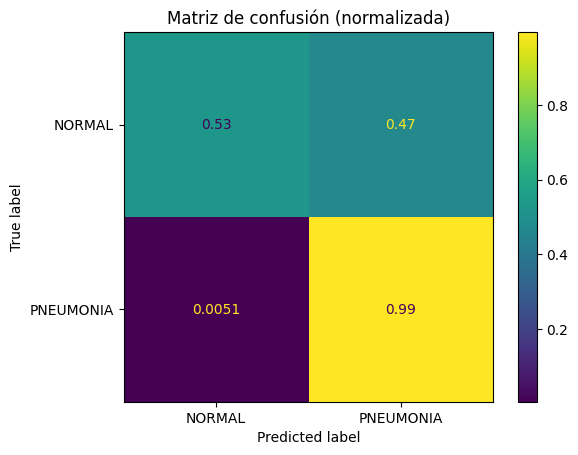

In [22]:
#  Evaluación final en TEST

# Carga mejor versión del modelo
best_path = "artifacts/best_model_resnet18.pth"
if os.path.exists(best_path):
    model.load_state_dict(torch.load(best_path, map_location=device))
    model.to(device)
    model.eval()
    print(f"Cargado checkpoint: {best_path}")
else:
    print("Aviso: no se encontró el checkpoint; se evaluará el último estado del modelo.")
    model.eval()

y_true, y_pred, y_prob = collect_probs_preds(model, test_loader, device)
acc = accuracy_score(y_true, y_pred)
prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="binary")

print("\n=== TEST ===")
print(f"Accuracy: {acc:.4f}  Precision: {prec:.4f}  Recall: {rec:.4f}  F1: {f1:.4f}")

def plot_confusion(y_true, y_pred, labels=None, normalize='true', save_path=None):
    fig, ax = plt.subplots()
    ConfusionMatrixDisplay.from_predictions(
        y_true, y_pred, display_labels=labels, normalize=normalize, ax=ax
    )
    ax.set_title("Matriz de confusión (normalizada)")
    plt.grid(False)

    if save_path is not None:
        fig.savefig(save_path, dpi=150, bbox_inches="tight")

    plt.show()

plot_confusion(y_true, y_pred, classes, normalize='true',
               save_path="artifacts/confusion_matrix_test.png")
# Guardar reporte csv simple

pd.DataFrame([{"split":"test","accuracy":acc,"precision":prec,"recall":rec,"f1":f1}]).to_csv("artifacts/test_metrics.csv", index=False)

Al analizar los resultados de la evaluación:
Se observa que el modelo detecta practicamente todas las PNEUMONIA, con un recall de 0.9949 lo que representa una alta sensibilidad del modelo, sin embargo este beneficio tiene un costo, presentando muchos falsos positivos (Precision 0.7791 y Accuracy de 0.8205), el valor de F1 es concordante con el equilibrio alto recall y precisión moderada.
Al analizar la matriz de confusión:
Se observa una baja especifidad del modelo, el 47%  de los estudios NORMAL se clasifican como PNEUMONIA (falsos positivos), sin embargo detecta el 99% de las PNEUMONIA, dejando muy poca patología sin identificar (falsos negativos) 0.51%.
Esto puede ocurrir por el umbral por defecto utilizado en el entrenamiento (como en este caso hay dos clases el umbral sería 0.5) del modelo lo que prioriza la sensibilidad, otro factor puede ser el desbalance de clases entre validación y test. Para mejorar la especificidad las opciones serían ajustar el umbral, o reajustar ponderación de clases, esto permite mover el equilibrio hacia la precisión sin perder demasiado recall.


## Conclusiones:

Se entrenó un clasificador CNN (ResNEt 18) con transfer learning, validación estratificada y pesos de clases para evitar el desbalance en los datos. Al analizar los resultados obtenidos, en validación se obtiene que F1 alcanzó un 0.996, con una brecha train-val baja, sin sobreajuste sostenido, indicando una buena generalización. En test el modelo mostró un recall de 0.995 y precisión de 0.78, lo que evidencia un sesgo de alta sensibilidad (detecta PNEUMONIA en pacientes sanos). La especificidad puede mejorar ajustando el umbral, y si se requiere se podría aginar la ponderación de clases, resolución o calibración. Para el futuro, se podrían considerar estrategias orientadas a reducir falsos positivos sin sacrificar la sensibilidad del modelo.
En general los resultados son prometedores para considerar la aplicación del modelo en procesos de triage, ya que son muy pocas las neumonías no detectadas, sin embargo esto tiene un costo en el alto número de falsos positivos generados, lo que clínicamente podría implicar más revisiones por parte de los clínicos en casos de pacientes sanos. 